In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,copy
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from scipy.io import loadmat
from scipy import linalg,interpolate
from csaps import csaps,NdGridCubicSmoothingSpline

from GDPT_handling_vibration import handling_vibration
from GDPT_import_data import import_data,folder
from GDPT_plot import plotstreamingfield
from helicity2vorticity import *

# 1. Import data

In [2]:
# Input parameters: here are providing two examples: w-1 and w-15, so,l = [-1,-15]

l = -1    
fps = 20
filepath = './GDPT_data/' 

folderpath,filename,eps = folder(l,filepath)
df=handling_vibration(import_data(folderpath),method = 'moving_average',window=15)

df.head()

the length of df before handling: 217213
the length of df after handling: 128915


,dat_Cm,dat_DX,dat_DY,dat_DZ,dat_ID,dat_In,dat_X,dat_Y,dat_Z
587,0.980394,0.000001,0.000001,-2.264536e-07,3,15,0.001410,0.001134,0.000197
624,0.985277,0.000001,0.000001,2.686258e-07,3,16,0.001411,0.001135,0.000197
663,0.981627,0.000001,0.000001,-6.681837e-08,3,17,0.001412,0.001136,0.000197
708,0.984752,0.000001,0.000001,-4.528075e-07,3,18,0.001413,0.001137,0.000197
751,0.988854,0.000001,0.000001,6.084009e-07,3,19,0.001414,0.001138,0.000197


# 2. Optimized data

H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:60: RuntimeWarning: invalid value encountered in true_divide
  vx = vx/rho
H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:61: RuntimeWarning: invalid value encountered in true_divide
  vy = vy/rho
H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:62: RuntimeWarning: invalid value encountered in true_divide
  vz = vz/rho


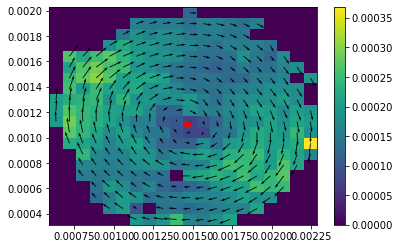

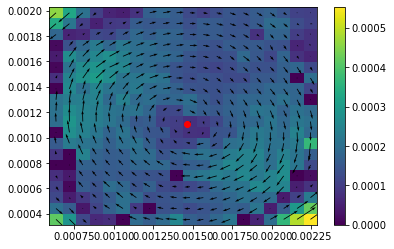

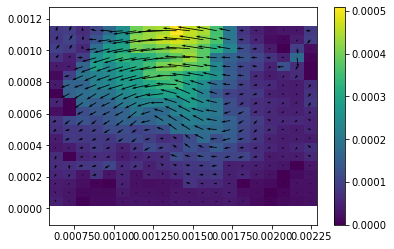

In [3]:
X0,Y0 = df[['dat_X','dat_Y']].mean()
high = 7

edges,rho,vx,vy,vz = particles2field(df,fps=fps,binsx=20,min_particles=3)
vnorm = np.sqrt(vx**2+vy**2+vz**2)
plt.plot(X0,Y0,'ro')
plt.pcolormesh(edges[0],edges[1],np.squeeze(vnorm[:,:,high]).T)
x,y,z = edges2centers(edges)
xv,yv = np.meshgrid(x,y,indexing='ij')
plt.colorbar()
plt.quiver(xv,yv,np.squeeze(vx[:,:,high]),np.squeeze(vy[:,:,high]))
if True:
    X,rho,v,omega,h = field2vorticity(edges,rho,vx,vy,vz,method='rbf',smooth=1)
    x,y,z= X
    vx,vy,vz = v
    vnorm = np.sqrt(vx**2+vy**2+vz**2)
    omegax,omegay,omegaz = omega
    
    plt.figure()
    plt.plot(X0,Y0,'ro')
    plt.pcolormesh(x,y,np.squeeze(vnorm[:,:,high]).T,shading='auto')#,shading='auto'
    plt.colorbar()
    plt.quiver(xv,yv,np.squeeze(vx[:,:,high]),np.squeeze(vy[:,:,high]))
    vnormxz = np.sqrt(vx**2+vz**2)
    plt.figure()
    xv,zv = np.meshgrid(x,z,indexing='ij')
    plt.pcolormesh(x,z,np.squeeze(vnormxz[:,high,:]).T,shading='auto')#,shading='auto'
    plt.colorbar()
    plt.quiver(xv,zv,np.squeeze(vx[:,high,:]),np.squeeze(vz[:,high,:]))
    plt.axis('equal')

# 3. Remove noise points

H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:222: RuntimeWarning: invalid value encountered in true_divide
  rms = np.sqrt(dvn2)/rho
H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:223: RuntimeWarning: invalid value encountered in true_divide
  rms_normalized = np.sqrt(dvn2)/(rho*vn)
H:\Jupyter Notebook workspace\Natcom\helicity2vorticity.py:224: RuntimeWarning: invalid value encountered in true_divide
  Cm = Cm/rho


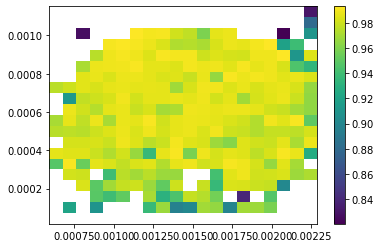

In [4]:
#--------------------find the wrong point-------------------

rms,rms_n,Cm = field_error(df,edges,vx,vy,vz,fps=fps)
plt.figure()
plt.pcolormesh(x,z,np.squeeze(Cm[:,7,:]).T,shading='auto')
plt.colorbar()

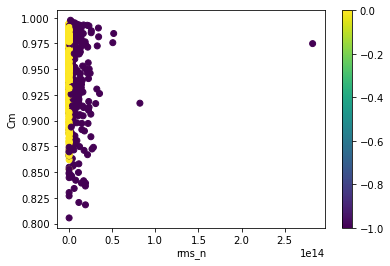

In [5]:
#-------------------------clean up the wrong points-----------------------------
high = 7

rhoc,vxc,vyc,vzc = cleanup(df,edges,rho,vx,vy,vz,fps=fps,eps=eps,plot=True)
_,rho1clean,_,_,_ = field2vorticity(edges,rhoc,vxc,vyc,vzc,method='griddata',smooth=1)
X1,rho1,v1,omega1,h1 = field2vorticity(edges,rhoc,vxc,vyc,vzc,method='rbf',smooth=1)
vx1,vy1,vz1 = v1
omegax1,omegay1,omegaz1 = omega1
discard = rho1clean<=10.
rho1[discard]=0.
vx1[discard]=0.
vy1[discard]=0.
vz1[discard]=0.
omegax1[discard]=0.
omegay1[discard]=0.
omegaz1[discard]=0.
h1[discard]=0.

Text(0.5, 1.0, 'clean up error 2')

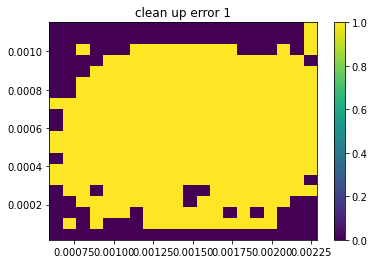

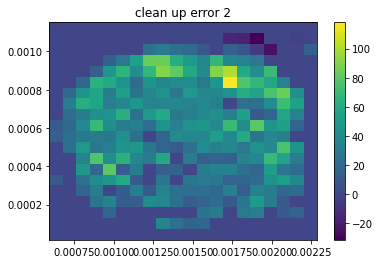

In [6]:
plt.figure()
plt.pcolormesh(x,z,np.squeeze(np.isfinite(Cm[:,7,:])).T,shading='auto')
plt.colorbar()
plt.title('clean up error 1')
plt.figure()
plt.pcolormesh(x,z,np.squeeze(rho1[:,7,:]).T,shading='auto')
plt.colorbar()
plt.title('clean up error 2')

0.00017690403588003752


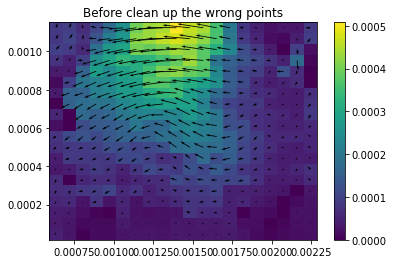

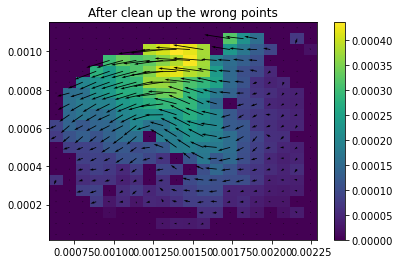

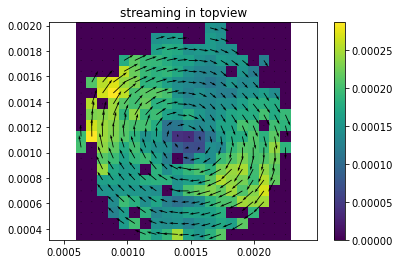

In [7]:
plt.figure()
xv,zv = np.meshgrid(x,z,indexing='ij')
plt.pcolormesh(x,z,np.squeeze(vnormxz[:,high,:]).T,shading='auto')
plt.colorbar()
plt.quiver(xv,zv,np.squeeze(vx[:,high,:]),np.squeeze(vz[:,high,:]))
plt.title('Before clean up the wrong points')

plt.figure()
vnormxz1 = np.sqrt(vx1**2+vz1**2)
xv,zv = np.meshgrid(x,z,indexing='ij')
plt.pcolormesh(x,z,np.squeeze(vnormxz1[:,high,:]).T,shading='auto')
plt.colorbar()
plt.quiver(xv,zv,np.squeeze(vx1[:,high,:]),np.squeeze(vz1[:,7,:]))
plt.title('After clean up the wrong points')

plt.figure()
vnormxy1 = np.sqrt(vx1**2+vy1**2)
print(np.mean(vnormxy1[:,:,high][rho1[:,:,high]>=5]))
xv,yv = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(x,y,np.squeeze(vnormxy1[:,:,high]).T,shading='auto')
plt.colorbar()
plt.quiver(xv,yv,np.squeeze(vx1[:,:,high]),np.squeeze(vy1[:,:,high]))
plt.title('streaming in topview')
plt.axis('equal')
plt.show()

# 4. Plot vorticity and helicity

Text(0.5, 1.0, 'helicity slice_sideview')

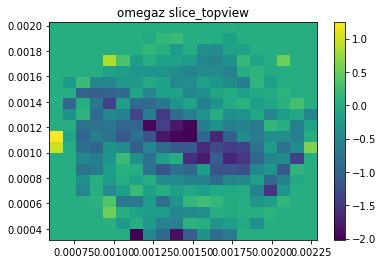

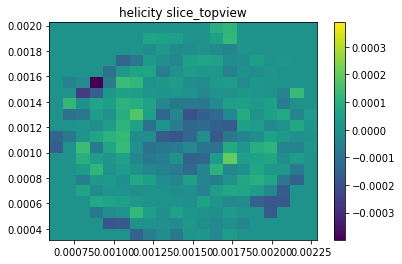

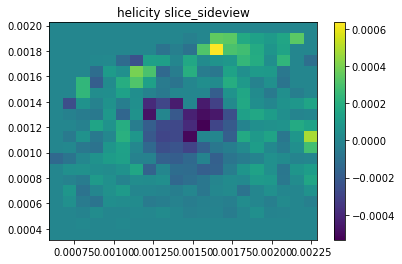

In [8]:
high=7

plt.figure()
plt.pcolormesh(x,y,np.squeeze(omegaz1[:,:,high]).T,shading='auto')
plt.title('omegaz slice_topview')
#plt.clim(-np.max(np.abs(omegaz1[:,:,c])),np.max(np.abs(omegaz[:,:,c])))
plt.colorbar()
plt.figure()
plt.pcolormesh(x,y,np.squeeze(h1[:,:,high]).T,shading='auto')
plt.title('helicity slice_topview')
plt.clim(-np.max(np.abs(h1[:,:,high])),np.max(np.abs(h[:,:,high])))
plt.colorbar()
plt.figure()
plt.pcolormesh(x,y,np.squeeze(h1[:,9,:]).T,shading='auto')
plt.colorbar()
plt.title('helicity slice_sideview')

# 5. Calcuate helicity, vorticity, veolicity 

In [9]:
A_GDPT,H,vorticity,H_star,Omega_star,H_norm,Omega_norm,average_speed,Volum_GDPT = calculate_helic(l,h1,rho,df,X1,X,omegax1,omegay1,vx1,vy1,vz1)
print('----------------------------------------------------------------')
print('A_GDPT(W_{0}) = {1} nm'.format(l,round(A_GDPT,2)))
print('H_{0} = {1}'.format(l,H))
print('H_star = ', H_star)
print('H_{0}/H_star = {1}'.format(l,H/H_star))
print('----------------------------------------------------------------')
print('vorticity (Omegatheta/V):',vorticity)
print('Omegastar = ', Omega_star)
print('0mega/Omega_star = ',vorticity/Omega_star )
print('----------------------------------------------------------------')
print('the average speed in the droplet: {0} m/s'.format(average_speed))
print('the volum in GDPT:{0} uL'.format(round(Volum_GDPT,2)))

----------------------------------------------------------------
A_GDPT(W_-1) = 1.07 nm
H_-1 = -8.656414545450923e-15
H_star =  -7.224068799175922e-15
H_-1/H_star = 1.1982741009385727
----------------------------------------------------------------
vorticity (Omegatheta/V): 0.01337492617945132
Omegastar =  1.1879707049145038
0mega/Omega_star =  0.011258632998373382
----------------------------------------------------------------
the average speed in the droplet: 0.00016808919046399135 m/s
the volum in GDPT:1.11 uL


# 6. Axial and azimuthal streaming analied by GDPT

In [11]:
keys = ['dat_X','dat_Y','dat_Z','dat_DX','dat_DY','dat_DZ']
for i in keys:
    df.loc[:,i] *= 1e6             # convert unit from m to um

Azimuthal velocity field. Max speed is 379 um/s
Axial velocity field. Max speed is 155 um/s


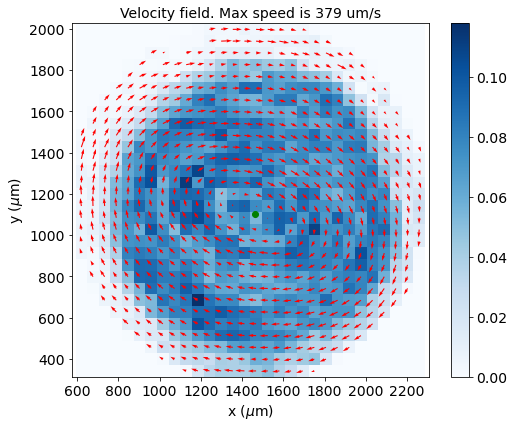

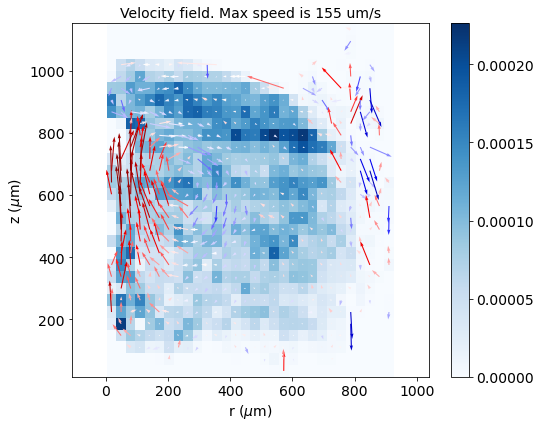

In [14]:
X0,Y0 = df[['dat_X','dat_Y']].mean()
fontsize=14
figsize=[8,6.5]
keys = {'x':'dat_X',
           'y':'dat_Y',
           'vx':'dat_DX',
           'vy':'dat_DY',
           'backgnd':1}
plotstreamingfield(df,keys,method = 'normlize',rhomin=5.,vlimit=6000,
            figsize=figsize,fontsize=fontsize,cmap_font='Blues',cmap='seismic_r',arrow_color='red',
            fps=fps,X0=X0,Y0=Y0,plt_point =True,title=True,scale=None)#[8,5]

keys = {'x':'R',
           'y':'dat_Z',
           'vx':'vR',
           'vy':'dat_DZ',
           'backgnd':'normalized_density'}
plotstreamingfield(df,keys,method = 'normlize',rhomin=5.,vlimit=600,
           figsize=figsize,fontsize=fontsize,cmap_font='Blues',cmap='seismic',arrow_color='vy',
           fps=fps,X0=X0,Y0=Y0,plt_point =False,title=True,viewer='axial',scale=None)#viewer represents the axis